In [1]:
%load_ext autoreload
%autoreload 2

Si uso un input size de 512x512, la última feature de una resnet me da 16x16(=256, que es lo mínimo que necesito para detectar todas las geoms).

In [2]:
import timm
import torch 

r18 = timm.create_model('resnet18', features_only=True)
fs = r18(torch.randn(5, 3, 512, 512))
for f in fs:
	print(f.shape)

torch.Size([5, 64, 256, 256])
torch.Size([5, 64, 128, 128])
torch.Size([5, 128, 64, 64])
torch.Size([5, 256, 32, 32])
torch.Size([5, 512, 16, 16])


Esto se lo paso a dos conv layers para sacar polys y lines.

In [3]:
polys = torch.nn.Conv2d(512, 148+1, 3, padding=1)(fs[-1])
lines = torch.nn.Conv2d(512, 28+1, 3, padding=1)(fs[-1])

polys.shape, lines.shape

(torch.Size([5, 149, 16, 16]), torch.Size([5, 29, 16, 16]))

Si hago un rearrange de las últimas dos dims, obtengo el número de geoms.

In [4]:
from einops import rearrange

polys = rearrange(polys, 'b c h w -> b c (h w)')
lines = rearrange(lines, 'b c h w -> b c (h w)')

polys.shape, lines.shape

(torch.Size([5, 149, 256]), torch.Size([5, 29, 256]))

In [5]:
from src.dm import BaselineDM

dm = BaselineDM()
dm.setup()

In [6]:
dm.df

,image,location,label,date
0,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
1,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
2,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
3,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
4,/fastdata/SN8/tarballs/Germany_Training_Public...,Germany_Training_Public,/fastdata/SN8/tarballs/Germany_Training_Public...,pre
...,...,...,...,...
1597,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1598,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1599,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post
1600,/fastdata/SN8/tarballs/Louisiana-East_Training...,Louisiana-East_Training_Public,/fastdata/SN8/tarballs/Louisiana-East_Training...,post


In [29]:
dm = BaselineDM(trans={
	'center_crop': {'size': (512, 512), 'p': 1},
	# 'random_crop': {'size': (512, 512), 'p': 1.},
})

dm.setup()

In [179]:
from geopandas import GeoSeries

def get_geom(y1, mask, shape, Geom, close=False):
	geom, geom_flooded = [], []
	for row, row2 in zip(y1, mask):
		if row2[0]:
			_geom = []
			for ix in range(0, y1.shape[1], 2):
				y, x = row[ix], row[ix+1]
				if row2[ix]:					
					_geom.append((y*shape[1],x*shape[2]))
			if close:
				_geom.append(_geom[0]) # close with first point
			if row2[-1]:
				geom_flooded.append(_geom)
			else:
				geom.append(_geom)
	return GeoSeries([Geom(l) for l in geom]), GeoSeries([Geom(l) for l in geom_flooded])

/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


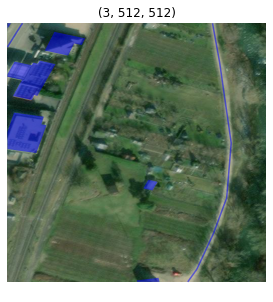

In [180]:
from rasterio.plot import show 
import matplotlib.pyplot as plt
import random 
from shapely.geometry import LineString, Polygon

# img, geom, transform, date, y1, y2 = dm.ds_train[random.randint(0, len(dm.ds_train))]
# img, geom, transform, date, y1, y2 = dm.ds_train[0]

img, y1, y2, mask1, mask2 = dm.ds_train[0]
# img, y1, y2, mask1, mask2 = dm.ds_train[random.randint(0, len(dm.ds_train))]

fig = plt.figure(figsize=(5,5))
# ax = plt.subplot(121)
ax = plt.subplot(111)
ax.imshow(img.transpose(1,2,0))
# flooded = geom[geom.flooded == 'yes']
# if len(flooded) > 0:
# 	flooded.plot(ax=ax, color='blue', alpha=0.5)
# no_flooded = geom[geom.flooded != 'yes']
# if len(no_flooded) > 0:
# 	no_flooded.plot(ax=ax, color='red', alpha=0.5)
# ax.set_title(f'{date} - {img.shape}')
ax.set_title(img.shape)
ax.axis('off')
# ax = plt.subplot(122)
ax.imshow(img.transpose(1,2,0))
lines, lines_flooded = get_geom(y1, mask1, img.shape, LineString)
lines.plot(ax=ax, color='red', alpha=0.5)
lines_flooded.plot(ax=ax, color='blue', alpha=0.5)
polys, polys_flooded = get_geom(y2, mask2, img.shape, Polygon, close=True)
polys.plot(ax=ax, color='red', alpha=0.5)
polys_flooded.plot(ax=ax, color='blue', alpha=0.5)
ax.axis('off')
plt.show()

In [159]:
batch = next(iter(dm.train_dataloader(shuffle=False)))
imgs, lines, polys, lines_mask, polys_mask = batch 

imgs.shape, polys.shape, lines.shape

(torch.Size([1, 3, 512, 512]),
 torch.Size([1, 149, 256]),
 torch.Size([1, 29, 256]))

In [160]:
from src.module import Module

hparams = {
	'backbone': 'resnet18',
	'pretrained': False,
	'optimizer': 'Adam',
	'optimizer_params': {'lr': 0.001},
}

module = Module(hparams)

pred_lines, pred_polys, pred_lines_mask, pred_polys_mask = module(imgs)

pred_polys.shape, pred_lines.shape

(torch.Size([1, 149, 256]), torch.Size([1, 29, 256]))

Fit one sample

In [237]:
import pytorch_lightning as pl

dm = BaselineDM(batch_size=1, trans={
	'center_crop': {'size': (512, 512), 'p': 1},
	# 'random_crop': {'size': (512, 512), 'p': 1.},
})

hparams = {
	'backbone': 'resnet18',
	'pretrained': False,
	'optimizer': 'Adam',
	'optimizer_params': {'lr': 0.001},
}

module = Module(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=500,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type           | Params
---------------------------------------------------
0 | backbone        | FeatureListNet | 11.2 M
1 | polys_head      | Conv2d         | 686 K 
2 | lines_head      | Conv2d         | 133 K 
3 | polys_mask_head | Conv2d         | 686 K 
4 | lines_mask_head | Conv2d         | 133 K 
--------------------------------------------------

Training: 0it [00:00, ?it/s]

/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


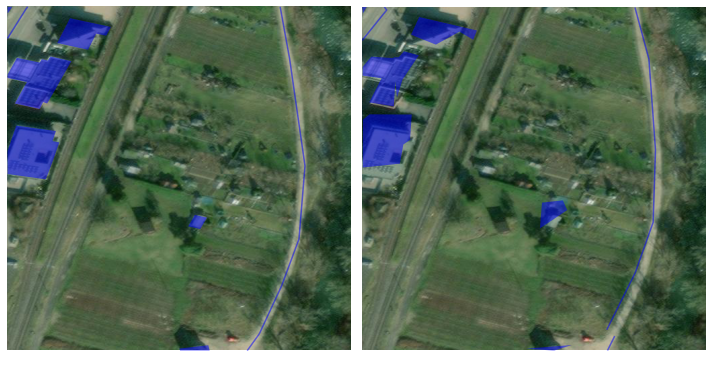

In [238]:
batch = next(iter(dm.train_dataloader(shuffle=False)))
imgs, lines, polys, lines_mask, polys_mask = batch 

pred_lines, pred_polys, pred_lines_mask, pred_polys_mask = module.predict(imgs)

fig = plt.figure(figsize=(10,20))
ax = plt.subplot(121)
img = imgs[0]
ax.imshow(img.permute(1,2,0))
ax.axis('off')
_lines, lines_flooded = get_geom(lines[0], lines_mask[0], img.shape, LineString)
_lines.plot(ax=ax, color='red', alpha=0.5)
lines_flooded.plot(ax=ax, color='blue', alpha=0.5)
_polys, polys_flooded = get_geom(polys[0], polys_mask[0], img.shape, Polygon, close=True)
_polys.plot(ax=ax, color='red', alpha=0.5)
polys_flooded.plot(ax=ax, color='blue', alpha=0.5)
ax.axis('off')
ax = plt.subplot(122)
ax.imshow(img.permute(1,2,0))
ax.axis('off')
_lines, lines_flooded = get_geom(pred_lines[0], pred_lines_mask[0], img.shape, LineString)
_lines.plot(ax=ax, color='red', alpha=0.5)
lines_flooded.plot(ax=ax, color='blue', alpha=0.5)
_polys, polys_flooded = get_geom(pred_polys[0], pred_polys_mask[0], img.shape, Polygon, close=True)
_polys.plot(ax=ax, color='red', alpha=0.5)
polys_flooded.plot(ax=ax, color='blue', alpha=0.5)
ax.axis('off')
plt.tight_layout()
plt.show()

Fit one batch

In [243]:
import pytorch_lightning as pl

dm = BaselineDM(batch_size=5, trans={
	'center_crop': {'size': (512, 512), 'p': 1},
	# 'random_crop': {'size': (512, 512), 'p': 1.},
})

hparams = {
	'backbone': 'resnet18',
	'pretrained': False,
	'optimizer': 'Adam',
	'optimizer_params': {'lr': 0.001},
}

module = Module(hparams)

trainer = pl.Trainer(
	gpus=1,
	precision=16,
	overfit_batches=1,
	max_epochs=100,
	logger=None,
	enable_checkpointing=False,
)

trainer.fit(module, dm)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name            | Type           | Params
---------------------------------------------------
0 | backbone        | FeatureListNet | 11.2 M
1 | polys_head      | Conv2d         | 686 K 
2 | lines_head      | Conv2d         | 133 K 
3 | polys_mask_head | Conv2d         | 686 K 
4 | lines_mask_head | Conv2d         | 133 K 
--------------------------------------------------

Training: 0it [00:00, ?it/s]

/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/envs/sn8/lib/python3.8/site-packages/geopandas/plotting.py:399: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/home/juan/miniconda3/env

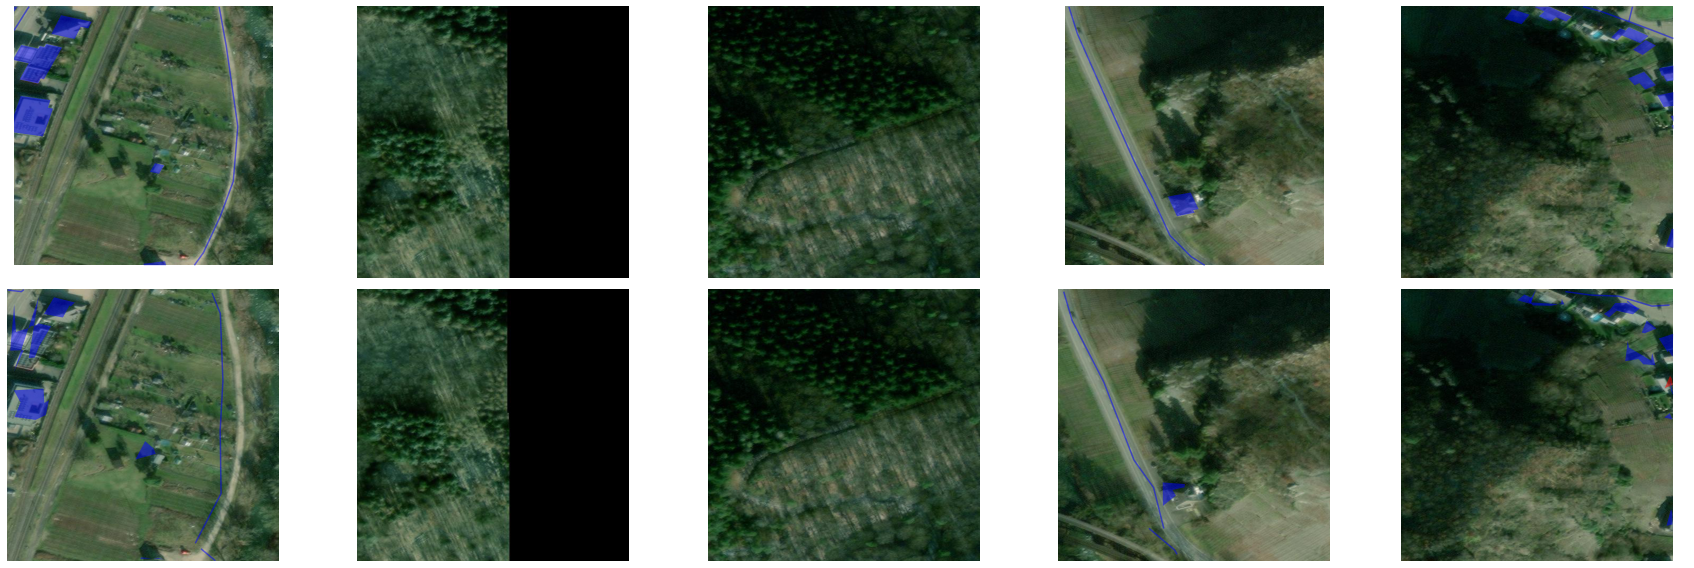

In [244]:
batch = next(iter(dm.train_dataloader(shuffle=False)))
imgs, lines, polys, lines_mask, polys_mask = batch 

pred_lines, pred_polys, pred_lines_mask, pred_polys_mask = module.predict(imgs)

fig = plt.figure(figsize=(5*len(imgs), 8))
for ix, img in enumerate(imgs):
	ax = plt.subplot(2, len(imgs), ix + 1)
	ax.imshow(img.permute(1,2,0))
	ax.axis('off')
	_lines, lines_flooded = get_geom(lines[ix], lines_mask[ix], img.shape, LineString)
	_lines.plot(ax=ax, color='red', alpha=0.5)
	lines_flooded.plot(ax=ax, color='blue', alpha=0.5)
	_polys, polys_flooded = get_geom(polys[ix], polys_mask[ix], img.shape, Polygon, close=True)
	_polys.plot(ax=ax, color='red', alpha=0.5)
	polys_flooded.plot(ax=ax, color='blue', alpha=0.5)
	ax.axis('off')
	ax = plt.subplot(2, len(imgs), len(imgs) + ix + 1)
	ax.imshow(img.permute(1,2,0))
	ax.axis('off')
	_lines, lines_flooded = get_geom(pred_lines[ix], pred_lines_mask[ix], img.shape, LineString)
	_lines.plot(ax=ax, color='red', alpha=0.5)
	lines_flooded.plot(ax=ax, color='blue', alpha=0.5)
	_polys, polys_flooded = get_geom(pred_polys[ix], pred_polys_mask[ix], img.shape, Polygon, close=True)
	_polys.plot(ax=ax, color='red', alpha=0.5)
	polys_flooded.plot(ax=ax, color='blue', alpha=0.5)
	ax.axis('off')
plt.tight_layout()
plt.show()